**4. CC_to_minF_scipy: 	Pruned_clique_complex -> Knill’s min F from scipy P**

Explore phase transitions for free energy by changing temperature and obtaining minimizing P.
-	Free energy vs temp for at least two probability strategies (scipy minimization and counting occurrences?)
-	If we may have bifurcation, one need to do several copies/simulations for the same network/brain
-	Compute this in a random graph, a scale free graph (similar size as brain)
-	Compute in a fmri based in mut info
-	Compute in structural connector (see dropbox Fernando sent - see Jupiter notes).

**Obtain the minimum free energy for a given clique complex**

In [111]:
# Import libraries
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from itertools import tee,combinations
import networkx as nx

In [5]:
clique_complex_list = [[frozenset({1}), frozenset({2}), frozenset({1, 2})],
 [frozenset({2}), frozenset({3}), frozenset({2, 3})],
 [frozenset({1}), frozenset({4}), frozenset({6}), frozenset({1, 4, 6})]]

In [105]:
# Define shannon entropy function
def shannon_entropy(probabilities):
    # Remove any zero probabilities to avoid log(0) issues
    probabilities = probabilities[probabilities != 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Internal energy function
def energy_function(x, Q):
    return x.T @ Q @ x

# Free energy function
def free_energy_function(x, Q, t):
    entropy_term = - np.sum(x * np.log2(np.maximum(x, 1e-10)))  # Avoid log(0), changed to np.log2 to improve speed.
    return t*(x.T @ Q @ x) - (1-t) * entropy_term

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse connectivity matrix
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix

# Find the minimum free energy for a given clique complex
def complete_f_generator_scipy(clique_complex, t):
    Q = generate_inverse_connectivity_matrix(clique_complex)[1]

    # Optimization settings
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(1e-10, None) for _ in range(len(Q))]
    x0 = np.full(len(Q), 1/len(Q))  # Initial guess

    # Store the latest optimized x0 and all free energies during minimization
    latest_x0 = None
    all_values = []

    # Callback function to collect values during minimization
    def callback(x):
        all_values.append(free_energy_function(x, Q, t))

    #for t in t_values:
    #    result = minimize(objective, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds)
    #    minimized_values.append(result.fun)
    #    latest_x0 = result.x  # Update the latest optimized x0

    result = minimize(free_energy_function, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds, callback=callback)
    return [result.fun, result.x]

def complete_f_generator(clique_complex):
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_list = []
    temperature_list = np.arange(0, 1, 0.1)

    for temperature in temperature_list:
        f = complete_f_generator_scipy(clique_complex, temperature)[0]
        f_list.append(f)

    return f_list, temperature_list, min_energy_value, max_entropy_value

c:\Users\cyril\anaconda3\envs\TDA_brain\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


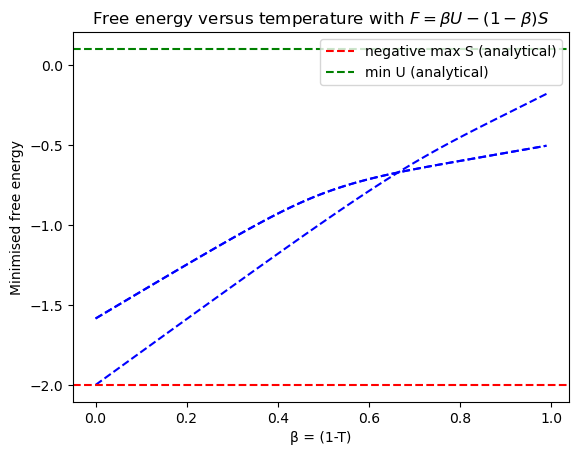

In [7]:
for i in range(0, len(clique_complex_list)):
    f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex_list[i])
    plt.plot(temperature_list, f_list, 'b--')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

In [8]:
import networkx as nx
import itertools

# Define a function to generate the clique complex from the list of cliques
def generate_clique_complex(cliques):
    clique_complex = []
    for clique in cliques:
        # Sort the nodes in the clique to maintain the order
        clique.sort()
        # Generate all possible subsets of nodes (simplices)
        for i in range(1, len(clique) + 1):
            simplices = [frozenset(sorted(subset)) for subset in itertools.combinations(clique, i)]
            clique_complex.extend(sorted(simplices))
    return clique_complex

# Generate a random graph
num_nodes = 10
probability = 0.3
dataset_size = 10
clique_complex_list = []

# Generate random clique_complex_list
for i in range(0, dataset_size):
    random_graph = nx.erdos_renyi_graph(num_nodes, probability)
    maximal_cliques = list(nx.find_cliques(random_graph))
    clique_complex = generate_clique_complex(maximal_cliques)
    clique_complex_list.append(clique_complex)

In [9]:
for i in range(0, len(clique_complex_list)):
    f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex_list[i])
    plt.plot(temperature_list, f_list, 'r--')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

LinAlgError: Singular matrix

# Phase transition with Pearson Correlation

In [62]:
# Import data
#matrix = np.genfromtxt('1000_Functional_Connectomes\Connectivity matrices\AveragedMatrix.txt')
matrix = np.genfromtxt('1000_Functional_Connectomes\Connectivity matrices\Baltimore_5568_connectivity_matrix_file.txt')
matrix = np.abs(matrix)

# Import external background functions
%run background_functions.py

<>:3: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
C:\Users\cyril\AppData\Local\Temp\ipykernel_30016\2757725813.py:3: SyntaxWarning: invalid escape sequence '\C'
  matrix = np.genfromtxt('1000_Functional_Connectomes\Connectivity matrices\Baltimore_5568_connectivity_matrix_file.txt')


In [63]:
# Define desired settings
cutoff=0.7 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=3
density = 0.9

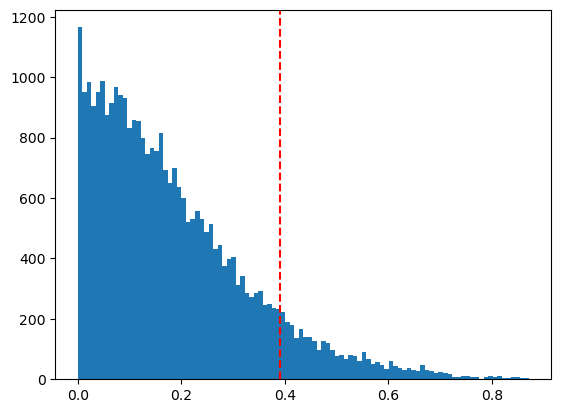

The value that contains 90% of all the values is: 0.39134088


In [64]:
def find_density_value(matrix, density):
    lst = matrix.flatten()

    # Step 1: Sort the list
    sorted_lst = sorted(lst)
    
    # Step 2: Calculate the index for 80% of the length
    density_index = int(density * len(sorted_lst))
    
    # Step 3: Return the value at the calculated index
    threshold = sorted_lst[density_index]

    # Plot the threshold
    plt.hist(lst, bins=100)
    plt.axvline(x=threshold, color='red', linestyle='--')
    plt.show()
    return threshold

# Example usage:
values = matrix
density = 0.9
result = find_density_value(values, density)
print("The value that contains 90% of all the values is:", result)

In [65]:
# Define a function to obtain a list the simplexes present in the simplicial complex, by counting the complete subgraphs in the connection matrix
def build_clique_complex_density(correlation_matrix, density, max_clique_size):

    # Find the threshold value for a given density
    lst = correlation_matrix.flatten()
    sorted_lst = sorted(lst)
    density_index = int(density * len(sorted_lst))
    threshold = sorted_lst[density_index]

    # Generate a graph for the given threshold value
    n = correlation_matrix.shape[0]
    G = nx.Graph()
    for i in range(n):
        for j in range(i + 1, n):
            if abs(correlation_matrix[i, j]) > threshold:
                G.add_edge(i, j)

    # Using nx.enumerate_all_cliques in an interactive manner
    seen_cliques = set()
    nodes_list = [set([i]) for i in range(len(correlation_matrix))] # Add nodes otherwise only > 1-simplexes are included in the clique_complex
    all_cliques = list(nx.enumerate_all_cliques(G)) + nodes_list
    for clique in all_cliques:

        if len(clique) > max_clique_size:
            break
        unique_clique = tuple(sorted(clique))
        seen_cliques.add(unique_clique)

    # Building the clique complex
    clique_complex = [frozenset(clique) for clique in seen_cliques]

    # Sort the list of sets based on the length of cliques and sorted vertices within each clique
    clique_complex = sorted(clique_complex, key=lambda x: (len(x), sorted(x)))

    return clique_complex

In [66]:
clique_complex = build_clique_complex_density(matrix, density, max_dim)

31329
0.9
0.39134088


In [67]:
print(len(clique_complex))

7019


In [12]:
# Compute the clique complex and Euler Characteristic
%time euler_characteristic, clique_complex = compute_euler(matrix,cutoff,max_dim)

CPU times: total: 15.6 ms
Wall time: 5.19 ms


In [13]:
# Generate the connectivity matrix L from the clique complex
%time inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

CPU times: total: 62.5 ms
Wall time: 22.7 ms


In [70]:
%time f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex)

KeyboardInterrupt: 

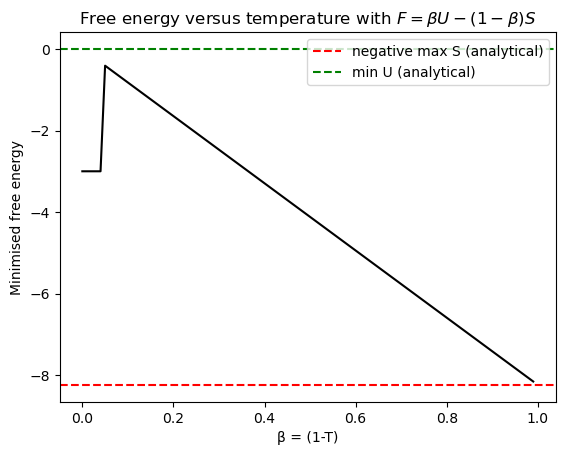

In [15]:
plt.scatter(temperature_list, f_list, color='black')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

**For random clique_complex of same shape**

In [17]:
import random
import itertools

def count_frozenset_dimensions(frozenset_list):
    max_dimension = max(len(fs) for fs in frozenset_list)
    count_list = [0] * (max_dimension)
    for fs in frozenset_list:
        dimension = len(fs)
        if dimension > 0:
            count_list[dimension - 1] += 1
    return count_list

def generate_random_tuplets(input_list, length, dimension):
    input_list = list(itertools.chain.from_iterable(input_list))
    triplets = []
    # Generate all possible combinations of triplets
    all_triplets = itertools.combinations(input_list, dimension)
    all_triplets = list(all_triplets)  # Convert generator to list for random sampling
    
    # Randomly select 'length' number of triplets
    selected_triplets = random.sample(all_triplets, length)
    return selected_triplets

def generate_pair_combinations(triple_list, dimension):
    pair_combinations = []
    for triple in triple_list:
        pairs = list(itertools.combinations(triple, dimension))
        pair_combinations.extend(pairs)
    return pair_combinations

def generate_random_clique_complex(clique_amounts):
    input_list = [(i,) for i in range(1, clique_amounts[0] + 1)]
    clique_complex = []
    tuples = []

    for i in reversed(clique_amounts[1:]):
        dimension = clique_amounts.index(i)+1
        clique_amount = i-len(tuples)
        print(clique_amount)
        if clique_amount >= 0:
            tuples += generate_random_tuplets(input_list, clique_amount, dimension)
        clique_complex += tuples
        tuples = generate_pair_combinations(tuples, dimension-1)

    clique_complex += input_list
    #clique_complex = clique_complex[::-1]
    return clique_complex

REST_state = 'REST1'

# Read the CSV file and extract the first and second columns as lists
df_InfoCoho = pd.read_csv(f'InfoCoho_{REST_state}.txt', sep='\t')
ID_list = df_InfoCoho['identification_code'].tolist()
clique_complex_list = df_InfoCoho.iloc[:, 3].apply(eval).tolist()
clique_complex = clique_complex_list[1]

clique_amounts = count_frozenset_dimensions(clique_complex)
#clique_amounts = [177, 50, 9, 2]
print(clique_amounts)
random_clique_complex = generate_random_clique_complex(clique_amounts)
random_clique_complex = [frozenset(item) for item in random_clique_complex]
print(count_frozenset_dimensions(random_clique_complex))
print(len(random_clique_complex))
print(len(clique_complex))
print(random_clique_complex)

[20, 3, 26]
26
-75
[20, 78, 26]
124
49
[frozenset({2, 18, 5}), frozenset({8, 5, 15}), frozenset({9, 3, 20}), frozenset({11, 12, 15}), frozenset({17, 14, 7}), frozenset({2, 4, 20}), frozenset({10, 6, 7}), frozenset({9, 4, 14}), frozenset({8, 9, 19}), frozenset({18, 6, 15}), frozenset({17, 11, 4}), frozenset({17, 3, 6}), frozenset({12, 20, 14}), frozenset({18, 19, 13}), frozenset({16, 9, 6}), frozenset({17, 20, 6}), frozenset({2, 19, 6}), frozenset({2, 11, 12}), frozenset({16, 2, 3}), frozenset({11, 13, 6}), frozenset({17, 12, 6}), frozenset({9, 18, 13}), frozenset({3, 5, 7}), frozenset({2, 19, 7}), frozenset({17, 2, 4}), frozenset({17, 4, 20}), frozenset({2, 5}), frozenset({2, 18}), frozenset({18, 5}), frozenset({8, 5}), frozenset({5, 15}), frozenset({8, 15}), frozenset({9, 3}), frozenset({3, 20}), frozenset({9, 20}), frozenset({11, 12}), frozenset({11, 15}), frozenset({12, 15}), frozenset({14, 7}), frozenset({17, 7}), frozenset({17, 14}), frozenset({2, 4}), frozenset({2, 20}), frozense

In [18]:
random_clique_complex = [set(fs) for fs in random_clique_complex]
print(random_clique_complex)

[{2, 18, 5}, {8, 5, 15}, {9, 3, 20}, {11, 12, 15}, {17, 14, 7}, {2, 4, 20}, {10, 6, 7}, {9, 4, 14}, {8, 9, 19}, {18, 6, 15}, {17, 11, 4}, {17, 3, 6}, {12, 20, 14}, {18, 19, 13}, {16, 9, 6}, {17, 20, 6}, {2, 19, 6}, {2, 11, 12}, {16, 2, 3}, {11, 13, 6}, {17, 12, 6}, {9, 18, 13}, {3, 5, 7}, {2, 19, 7}, {17, 2, 4}, {17, 4, 20}, {2, 5}, {2, 18}, {18, 5}, {8, 5}, {5, 15}, {8, 15}, {9, 3}, {3, 20}, {9, 20}, {11, 12}, {11, 15}, {12, 15}, {14, 7}, {17, 7}, {17, 14}, {2, 4}, {2, 20}, {4, 20}, {6, 7}, {10, 6}, {10, 7}, {9, 4}, {4, 14}, {9, 14}, {8, 9}, {8, 19}, {9, 19}, {6, 15}, {18, 6}, {18, 15}, {11, 4}, {17, 4}, {17, 11}, {3, 6}, {17, 3}, {17, 6}, {12, 14}, {12, 20}, {20, 14}, {18, 13}, {19, 13}, {18, 19}, {9, 6}, {16, 6}, {16, 9}, {17, 6}, {20, 6}, {17, 20}, {2, 6}, {2, 19}, {19, 6}, {2, 11}, {2, 12}, {11, 12}, {2, 3}, {16, 2}, {16, 3}, {11, 6}, {13, 6}, {11, 13}, {12, 6}, {17, 6}, {17, 12}, {9, 13}, {9, 18}, {18, 13}, {3, 5}, {3, 7}, {5, 7}, {2, 7}, {2, 19}, {19, 7}, {2, 4}, {17, 2}, {17, 4

In [22]:
%time f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(random_clique_complex)

LinAlgError: Singular matrix

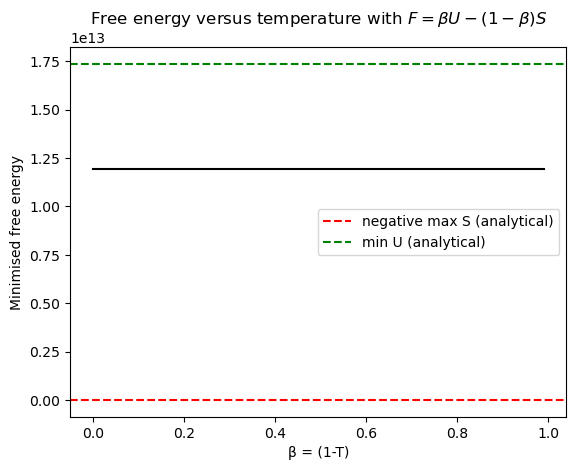

In [21]:
plt.plot(temperature_list, f_list, color='black')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

In [23]:
# Genrate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    np.savetxt('matrix.txt', matrix, fmt='%d')
    #plt.imshow(matrix)
    #plt.show()
    # Compute the inverse connectivity matrix
    #print(np.linalg.det(matrix))
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix


# Choose desired settings
REST_state = 'REST1'

# Read the CSV file and extract the first and second columns as lists
df_InfoCoho = pd.read_csv(f'InfoCoho_{REST_state}.txt', sep='\t')
ID_list = df_InfoCoho['identification_code'].tolist()
clique_complex_list = df_InfoCoho.iloc[:, 3].apply(eval).tolist()
clique_complex = clique_complex_list[1]
print(len(clique_complex))

clique_complex_list = [[frozenset({1}), frozenset({2}), frozenset({1, 2})],
 [frozenset({2}), frozenset({3}), frozenset({3, 2})],
 [frozenset({1}), frozenset({4}), frozenset({6}), frozenset({4, 1, 6})]]
#clique_complex = clique_complex_list[2]
print(count_frozenset_dimensions(clique_complex))
clique_complex = [set(fs) for fs in clique_complex]
clique_complex = clique_complex[::-1]
print(clique_complex)
inverse_matrix = generate_inverse_connectivity_matrix(clique_complex)[1]

49
[20, 3, 26]
[{18, 19, 20}, {17, 19, 20}, {17, 18, 20}, {19, 20, 14}, {18, 20, 14}, {17, 20, 14}, {9, 12, 15}, {12, 15, 7}, {11, 12, 7}, {9, 15, 7}, {9, 12, 7}, {19, 20, 6}, {20, 6, 14}, {4, 12, 15}, {9, 4, 15}, {9, 4, 12}, {4, 15, 7}, {4, 12, 7}, {3, 15, 7}, {1, 12, 15}, {1, 9, 15}, {1, 12, 9}, {1, 15, 7}, {1, 9, 7}, {1, 4, 15}, {1, 4, 9}, {18, 20}, {18, 19}, {17, 19}, {20}, {19}, {18}, {17}, {16}, {15}, {14}, {13}, {12}, {11}, {10}, {9}, {8}, {7}, {6}, {5}, {4}, {3}, {2}, {1}]


LinAlgError: Singular matrix

# WHYYYYYYYY

In [24]:
Real_data_complex = [{18, 19, 20}, {17, 19, 20}, {17, 18, 20}, {19, 20, 14}, {18, 20, 14}, {17, 20, 14}, {9, 12, 15}, {12, 15, 7}, {11, 12, 7}, {9, 15, 7}, {9, 12, 7}, {19, 20, 6}, {20, 6, 14}, {4, 12, 15}, {9, 4, 15}, {9, 4, 12}, {4, 15, 7}, {4, 12, 7}, {3, 15, 7}, {1, 12, 15}, {1, 9, 15}, {1, 12, 9}, {1, 15, 7}, {1, 9, 7}, {1, 4, 15}, {1, 4, 9}, {18, 20}, {18, 19}, {17, 19}, {20}, {19}, {18}, {17}, {16}, {15}, {14}, {13}, {12}, {11}, {10}, {9}, {8}, {7}, {6}, {5}, {4}, {3}, {2}, {1}]
Random_data_complex_singular = [{11, 4, 20}, {2, 18, 5}, {9, 13, 6}, {11, 13, 14}, {1, 2, 15}, {2, 19, 14}, {16, 10, 12}, {2, 10, 15}, {17, 18, 11}, {19, 4, 20}, {17, 18, 3}, {8, 10, 13}, {1, 5, 7}, {16, 19, 14}, {16, 2, 15}, {16, 15, 7}, {9, 11, 7}, {8, 10, 6}, {17, 19, 20}, {9, 4, 14}, {9, 13, 17}, {2, 19, 5}, {8, 11, 6}, {12, 13, 15}, {16, 10, 4}, {11, 12, 7}, {11, 4}, {4, 20}, {11, 20}, {2, 5}, {2, 18}, {18, 5}, {9, 6}, {13, 6}, {9, 13}, {11, 13}, {11, 14}, {13, 14}, {1, 2}, {1, 15}, {2, 15}, {2, 14}, {2, 19}, {19, 14}, {10, 12}, {16, 10}, {16, 12}, {2, 10}, {2, 15}, {10, 15}, {17, 11}, {18, 11}, {17, 18}, {19, 4}, {4, 20}, {19, 20}, {17, 3}, {18, 3}, {17, 18}, {8, 10}, {8, 13}, {10, 13}, {1, 5}, {1, 7}, {5, 7}, {16, 14}, {19, 14}, {16, 19}, {2, 15}, {16, 2}, {16, 15}, {15, 7}, {16, 7}, {16, 15}, {9, 7}, {11, 7}, {9, 11}, {8, 6}, {10, 6}, {8, 10}, {17, 19}, {17, 20}, {19, 20}, {9, 4}, {4, 14}, {9, 14}, {9, 13}, {9, 17}, {17, 13}, {2, 5}, {2, 19}, {19, 5}, {8, 6}, {11, 6}, {8, 11}, {12, 13}, {12, 15}, {13, 15}, {10, 4}, {16, 4}, {16, 10}, {11, 7}, {12, 7}, {11, 12}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]
Random_data_complex_unimodular = [{1, 2, 18}, {16, 20, 6}, {8, 5, 14}, {8, 2, 20}, {20, 6, 14}, {9, 11, 4}, {8, 19, 7}, {17, 3, 20}, {15, 6, 7}, {17, 4, 15}, {18, 12, 5}, {19, 3, 14}, {9, 4, 15}, {1, 12, 6}, {18, 11, 6}, {8, 3, 12}, {18, 12, 13}, {17, 10, 11}, {1, 3, 4}, {1, 18, 19}, {1, 12, 15}, {10, 20, 15}, {16, 5, 15}, {11, 12, 7}, {11, 13, 15}, {17, 12, 20}, {1, 2}, {1, 18}, {2, 18}, {16, 6}, {20, 6}, {16, 20}, {8, 5}, {5, 14}, {8, 14}, {8, 2}, {2, 20}, {8, 20}, {6, 14}, {20, 6}, {20, 14}, {9, 4}, {11, 4}, {9, 11}, {8, 7}, {19, 7}, {8, 19}, {17, 3}, {3, 20}, {17, 20}, {6, 7}, {6, 15}, {15, 7}, {4, 15}, {17, 4}, {17, 15}, {12, 5}, {18, 5}, {18, 12}, {3, 14}, {19, 3}, {19, 14}, {9, 4}, {4, 15}, {9, 15}, {1, 6}, {1, 12}, {12, 6}, {11, 6}, {18, 6}, {18, 11}, {8, 3}, {3, 12}, {8, 12}, {12, 13}, {18, 12}, {18, 13}, {10, 11}, {17, 10}, {17, 11}, {1, 3}, {1, 4}, {3, 4}, {1, 18}, {1, 19}, {18, 19}, {1, 12}, {1, 15}, {12, 15}, {10, 15}, {10, 20}, {20, 15}, {5, 15}, {16, 5}, {16, 15}, {11, 7}, {12, 7}, {11, 12}, {11, 13}, {11, 15}, {13, 15}, {17, 12}, {12, 20}, {17, 20}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]

In [25]:
# Import libraries
import numpy as np

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):

    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return inverse_connectivity_matrix


# Two clique complexes with 20 nodes, 78 edges and 26 triangles. The pairs are generated from random combinations of the nodes and the triangles from random combinations of the pairs.
Random_data_complex_singular = [{11, 4, 20}, {2, 18, 5}, {9, 13, 6}, {11, 13, 14}, {1, 2, 15}, {2, 19, 14}, {16, 10, 12}, {2, 10, 15}, {17, 18, 11}, {19, 4, 20}, {17, 18, 3}, {8, 10, 13}, {1, 5, 7}, {16, 19, 14}, {16, 2, 15}, {16, 15, 7}, {9, 11, 7}, {8, 10, 6}, {17, 19, 20}, {9, 4, 14}, {9, 13, 17}, {2, 19, 5}, {8, 11, 6}, {12, 13, 15}, {16, 10, 4}, {11, 12, 7}, {11, 4}, {4, 20}, {11, 20}, {2, 5}, {2, 18}, {18, 5}, {9, 6}, {13, 6}, {9, 13}, {11, 13}, {11, 14}, {13, 14}, {1, 2}, {1, 15}, {2, 15}, {2, 14}, {2, 19}, {19, 14}, {10, 12}, {16, 10}, {16, 12}, {2, 10}, {2, 15}, {10, 15}, {17, 11}, {18, 11}, {17, 18}, {19, 4}, {4, 20}, {19, 20}, {17, 3}, {18, 3}, {17, 18}, {8, 10}, {8, 13}, {10, 13}, {1, 5}, {1, 7}, {5, 7}, {16, 14}, {19, 14}, {16, 19}, {2, 15}, {16, 2}, {16, 15}, {15, 7}, {16, 7}, {16, 15}, {9, 7}, {11, 7}, {9, 11}, {8, 6}, {10, 6}, {8, 10}, {17, 19}, {17, 20}, {19, 20}, {9, 4}, {4, 14}, {9, 14}, {9, 13}, {9, 17}, {17, 13}, {2, 5}, {2, 19}, {19, 5}, {8, 6}, {11, 6}, {8, 11}, {12, 13}, {12, 15}, {13, 15}, {10, 4}, {16, 4}, {16, 10}, {11, 7}, {12, 7}, {11, 12}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]
Random_data_complex_unimodular = [{1, 2, 18}, {16, 20, 6}, {8, 5, 14}, {8, 2, 20}, {20, 6, 14}, {9, 11, 4}, {8, 19, 7}, {17, 3, 20}, {15, 6, 7}, {17, 4, 15}, {18, 12, 5}, {19, 3, 14}, {9, 4, 15}, {1, 12, 6}, {18, 11, 6}, {8, 3, 12}, {18, 12, 13}, {17, 10, 11}, {1, 3, 4}, {1, 18, 19}, {1, 12, 15}, {10, 20, 15}, {16, 5, 15}, {11, 12, 7}, {11, 13, 15}, {17, 12, 20}, {1, 2}, {1, 18}, {2, 18}, {16, 6}, {20, 6}, {16, 20}, {8, 5}, {5, 14}, {8, 14}, {8, 2}, {2, 20}, {8, 20}, {6, 14}, {20, 6}, {20, 14}, {9, 4}, {11, 4}, {9, 11}, {8, 7}, {19, 7}, {8, 19}, {17, 3}, {3, 20}, {17, 20}, {6, 7}, {6, 15}, {15, 7}, {4, 15}, {17, 4}, {17, 15}, {12, 5}, {18, 5}, {18, 12}, {3, 14}, {19, 3}, {19, 14}, {9, 4}, {4, 15}, {9, 15}, {1, 6}, {1, 12}, {12, 6}, {11, 6}, {18, 6}, {18, 11}, {8, 3}, {3, 12}, {8, 12}, {12, 13}, {18, 12}, {18, 13}, {10, 11}, {17, 10}, {17, 11}, {1, 3}, {1, 4}, {3, 4}, {1, 18}, {1, 19}, {18, 19}, {1, 12}, {1, 15}, {12, 15}, {10, 15}, {10, 20}, {20, 15}, {5, 15}, {16, 5}, {16, 15}, {11, 7}, {12, 7}, {11, 12}, {11, 13}, {11, 15}, {13, 15}, {17, 12}, {12, 20}, {17, 20}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]

# Compute inverse connectivity matrix
print(count_frozenset_dimensions(Random_data_complex_unimodular))
inverse_connectivity_matrix = generate_inverse_connectivity_matrix(Random_data_complex_unimodular)
print(inverse_connectivity_matrix)

print(count_frozenset_dimensions(Random_data_complex_singular))
inverse_connectivity_matrix = generate_inverse_connectivity_matrix(Random_data_complex_singular)
print(inverse_connectivity_matrix)

[20, 78, 26]
[[ 4.41270312e+00 -6.17880764e+00 -5.46918490e+01 ...  1.28534346e-01
  -9.36047106e-15 -8.65626172e-02]
 [-8.28433332e+00  1.77943226e+01  4.19505999e+00 ...  2.97332651e-01
   1.15237615e-14 -1.28067493e+00]
 [-7.49080845e+00 -9.61287646e+00 -2.38948829e+01 ... -2.82186011e-01
  -5.10702591e-16  9.95334091e-01]
 ...
 [-1.96537661e+00 -5.80462555e+00 -1.98594321e+00 ... -1.91815762e+00
  -6.69934300e-17 -1.76170796e-01]
 [-7.90673734e-01 -9.00905636e-01 -1.06531933e+00 ... -9.60898448e-02
  -2.00000000e+00  3.48233698e-01]
 [ 1.50405197e+00 -8.81521163e-01 -7.19580537e-01 ... -9.53168488e-02
   3.10256204e-15 -2.82106417e+00]]
[20, 78, 26]


LinAlgError: Singular matrix

# Phase transitions for artificial graphs

Define functions to generate: 
- a scale free graph for a given density
- an erdos renyi graph for a given density
- a real data graph for a given density
- a clique complex for a given graph
- a list a free energies over a range of temperatures for a given clique complex

In [300]:
# Define shannon entropy function
def shannon_entropy(probabilities):
    # Remove any zero probabilities to avoid log(0) issues
    probabilities = probabilities[probabilities != 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Internal energy function
def energy_function(x, Q):
    return x.T @ Q @ x

# Free energy function
def free_energy_function(x, Q, t):
    entropy_term = - np.sum(x * np.log2(np.maximum(x, 1e-10)))  # Avoid log(0), changed to np.log2 to improve speed.
    return t*(x.T @ Q @ x) - (1-t) * entropy_term

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse connectivity matrix
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix

# Find the minimum free energy for a given clique complex
def complete_f_generator_scipy(clique_complex, t):
    Q = generate_inverse_connectivity_matrix(clique_complex)[1]

    # Optimization settings
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(1e-10, None) for _ in range(len(Q))]
    x0 = np.full(len(Q), 1/len(Q))  # Initial guess

    # Store the latest optimized x0 and all free energies during minimization
    latest_x0 = None
    all_values = []

    # Callback function to collect values during minimization
    def callback(x):
        all_values.append(free_energy_function(x, Q, t))

    #for t in t_values:
    #    result = minimize(objective, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds)
    #    minimized_values.append(result.fun)
    #    latest_x0 = result.x  # Update the latest optimized x0

    result = minimize(free_energy_function, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds, callback=callback)
    return [result.fun, result.x]

# Obtain scipy minimized free energy and calculate the analytical minimum U and maximum S
def complete_f_generator(clique_complex):
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_list = []
    p_list = []
    temperature_list = np.arange(0, 1, 0.1)

    for temperature in temperature_list:
        f, p = complete_f_generator_scipy(clique_complex, temperature)
        f_list.append(f)
        p_list.append(p)

    return f_list, temperature_list, min_energy_value, min_energy_probabilities, max_entropy_value, p_Smax, p_list

# Generate a scale free graph (with nodal degrees distributed as powerlaw)
def generate_scale_free_graph(nodes, density):
    # Create a scale-free graph
    G = nx.scale_free_graph(n)

    # Undirected
    G = G.to_undirected()

    # Compute the total number of edges to keep
    total_edges = int((n * (n - 1)) / 2) * density

    # Calculate the number of edges to remove
    edges_to_remove = int(G.number_of_edges() - total_edges)

    # Remove edges to achieve the desired density
    if edges_to_remove > 0:
        G.remove_edges_from(list(G.edges())[:edges_to_remove])
    
    return G

# Generate a graph from real data for a given correlation matrix and density
def generate_real_data_graph(matrix, density, DIAGNOSTIC=False):
    # Fernando's function from network_TDA_tutorial
    np.fill_diagonal(matrix, 0)
    temp = sorted(matrix.ravel(), reverse=True)
    size = len(matrix)
    cutoff = np.ceil(density*(size*(size-1)))
    tre = temp[int(cutoff)]
    G0 = nx.from_numpy_matrix(matrix)
    G0.remove_edges_from(list(nx.selfloop_edges(G0)))
    G1 = nx.from_numpy_matrix(matrix)
    for u,v,a in G0.edges(data=True):
        if (a.get('weight')) <= tre:
            G1.remove_edge(u, v)
    finaldensity = nx.density(G1)
    if DIAGNOSTIC == True:
        print(finaldensity)
    return G1

# Build clique complex using gudhi to improve speed over networkx
def build_clique_complex_graph(G, max_clique_size):
    Cl = (i for i in nx.find_cliques(G))

    C = (tuple(sorted(c)) for c in Cl)
    C = tee(C, max_clique_size+1)

    cliques = [[] for _ in range(max_clique_size+1)]

    for i in range(max_clique_size+1):
        K = (i for i in set(c for mc in C[i] for c in combinations(mc, i+1)))
        for c in K:
            cliques[i].append(frozenset(c))

    result = []
    for i in range(max_clique_size+1):
        result.extend(sorted(cliques[i], key=lambda x: (len(x), sorted(x))))

    return result

# Generate average list of a list of lists
def average_list(list_of_lists):
    # Get the length of the first list to determine the size of the result list
    list_length = len(list_of_lists[0])
    
    # Initialize the result list with zeros
    avg_list = [0] * list_length
    
    # Iterate over each list element-wise and calculate the mean
    for sub_list in list_of_lists:
        avg_list = [sum(x) for x in zip(avg_list, sub_list)]
    
    # Divide each element in the result list by the number of lists
    avg_list = [x / len(list_of_lists) for x in avg_list]
    
    return avg_list

Import real data and libraries

In [177]:
# Import libraries
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from itertools import tee,combinations
import networkx as nx
import glob

# Import data
matrices = [np.genfromtxt(file) for file in glob.glob('1000_Functional_Connectomes\Connectivity matrices\*.txt')]

<>:11: SyntaxWarning: invalid escape sequence '\C'
<>:11: SyntaxWarning: invalid escape sequence '\C'
C:\Users\cyril\AppData\Local\Temp\ipykernel_30016\1162685669.py:11: SyntaxWarning: invalid escape sequence '\C'
  matrices = [np.genfromtxt(file) for file in glob.glob('1000_Functional_Connectomes\Connectivity matrices\*.txt')]


Generate real and artificial datasets

In [308]:
# Define desired settings and generate graph datasets
dataset_size = 50
density = 0.1
nodes = 116
CC_scale_free = []
CC_erdos_renyi = []
CC_real_data = []

for _ in range(dataset_size):
    # CC from scale free
    G = generate_scale_free_graph(nodes, density)
    clique_complex = build_clique_complex_graph(G, 3)
    CC_scale_free.append(clique_complex)

    # CC from erdos renyi
    #G = nx.erdos_renyi_graph(nodes, density)
    #clique_complex = build_clique_complex_graph(G, 3)
    #CC_erdos_renyi.append(clique_complex)

    # CC from real data
    #G = generate_real_data_graph(matrices[_], density, DIAGNOSTIC=False)
    #clique_complex = build_clique_complex_graph(G, 3)
    #CC_real_data.append(clique_complex)

Compute free energies for a range of temperatures for a desired dataset

In [309]:
f_list_iterations = []
p_list_iterations = []
P_Umin_list = []
P_Smax_list = []

for i in range(dataset_size):
    f_list, temperature_list, min_energy_value, min_energy_probabilities, max_entropy_value, max_entropy_probabilities, p_list = complete_f_generator(CC_scale_free[i])
    f_list_iterations.append(f_list)
    p_list_iterations.append(p_list)
    P_Umin_list.append(min_energy_probabilities)
    P_Smax_list.append(max_entropy_probabilities)

c:\Users\cyril\anaconda3\envs\TDA_brain\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Plot the free energy vs temperature

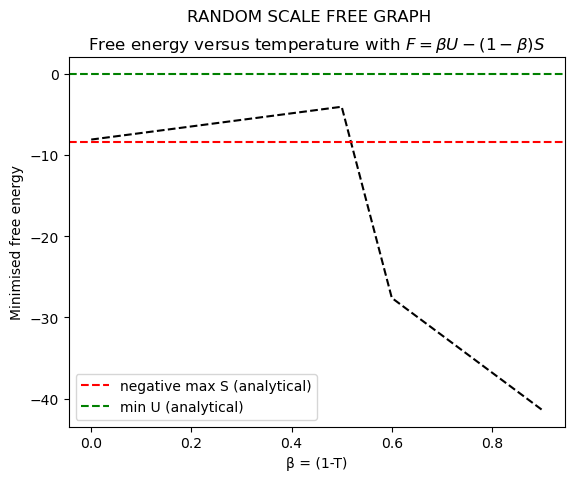

In [266]:
plt.plot(temperature_list, f_list_iterations[2], color='black', linestyle='--')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.suptitle('RANDOM SCALE FREE GRAPH')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

In [310]:
clique_complex = CC_scale_free[2]

N_nodes = sum(1 for s in clique_complex if len(s) == 1)
N_edges = sum(1 for s in clique_complex if len(s) == 2)
N_triangles = sum(1 for s in clique_complex if len(s) == 3)

# Define the x-values to mark the transition
marker_x_values = [N_nodes, (N_nodes+N_edges), (N_nodes+N_edges+N_triangles)]

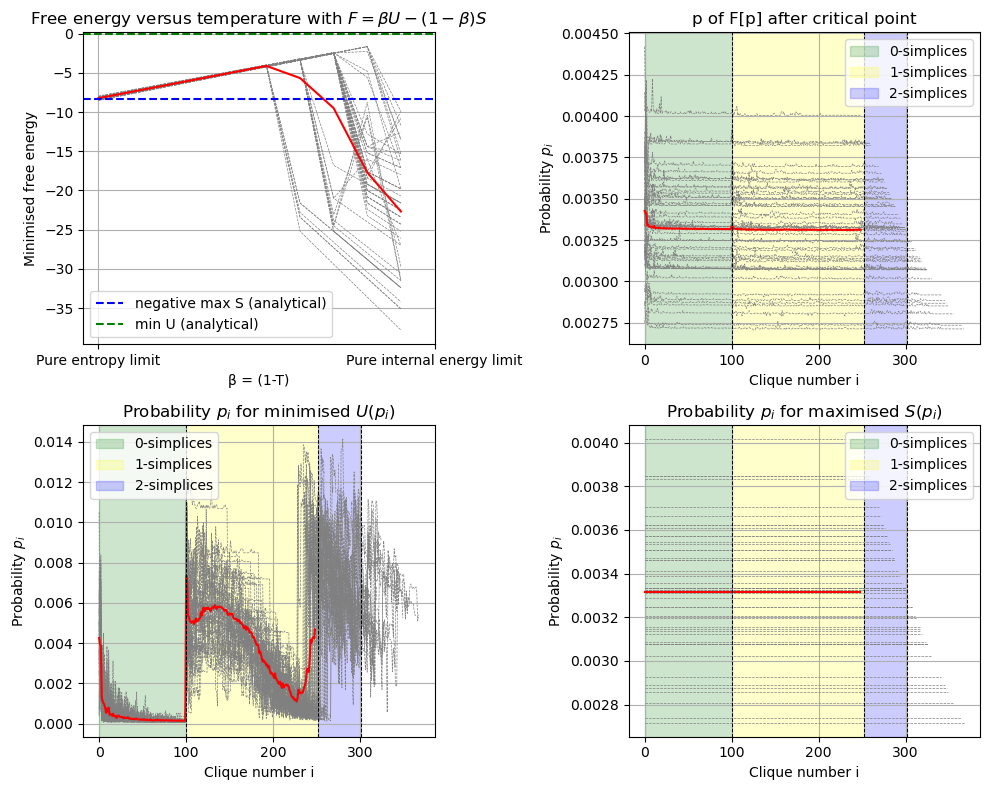

In [315]:
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot histograms
# F vs T
for i in range(dataset_size):
    axs[0, 0].plot(temperature_list, f_list_iterations[i], color='grey', linestyle='--', linewidth=0.5)
f_list_average = [sum(x) / len(x) for x in zip(*f_list_iterations)]
axs[0, 0].plot(temperature_list, f_list_average, color='red')

# Define custom tick positions and labels
custom_ticks = [0, 1]
custom_labels = ['Pure entropy limit', 'Pure internal energy limit']
axs[0, 0].set_xticks(custom_ticks)
axs[0, 0].set_xticklabels(custom_labels)

# Rest of plot
axs[0, 0].set_title('Free energy versus temperature with $F= β U - (1-β) S$')
axs[0, 0].set_xlabel('β = (1-T)')
axs[0, 0].set_ylabel('Minimised free energy')
axs[0, 0].axhline(y=-max_entropy_value, color='b', linestyle='--', label='negative max S (analytical)')
axs[0, 0].axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
axs[0, 0].grid(True)
axs[0, 0].legend()

# After phase transition
p_lists = []
for i in range(dataset_size):
    p_list = p_list_iterations[i]
    axs[0, 1].plot(p_list[3], color='grey', linestyle='--', linewidth=0.5)
    p_lists.append(p_list[3])
p_list_average = average_list(p_lists)
axs[0, 1].plot(p_list_average, color='red')
axs[0, 1].set_title('p of F[p] after critical point')
axs[0, 1].set_xlabel('Clique number i')
axs[0, 1].set_ylabel('Probability $p_i$')
axs[0, 1].grid(True)

for marker_x in marker_x_values:
    axs[0, 1].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

axs[0, 1].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
axs[0, 1].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
axs[0, 1].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
axs[0, 1].legend(loc='upper right')

# Pure energy
for i in range(dataset_size):
    axs[1, 0].plot(P_Umin_list[i], color='grey', linestyle='--', linewidth=0.5)
P_Umin_average = [sum(x) / len(x) for x in zip(*P_Umin_list)]
axs[1, 0].plot(P_Umin_average, color='red')
axs[1, 0].set_title('Probability $p_i$ for minimised $U(p_i)$')
axs[1, 0].set_xlabel('Clique number i')
axs[1, 0].set_ylabel('Probability $p_i$')
axs[1, 0].grid(True)

for marker_x in marker_x_values:
    axs[1, 0].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

axs[1, 0].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
axs[1, 0].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
axs[1, 0].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
axs[1, 0].legend()

# Pure entropy
for i in range(dataset_size):
    axs[1, 1].plot(P_Smax_list[i], color='grey', linestyle='--', linewidth=0.5)
P_Smax_average = [sum(x) / len(x) for x in zip(*P_Smax_list)]
axs[1, 1].plot(P_Smax_average, color='red')
axs[1, 1].set_title('Probability $p_i$ for maximised $S(p_i)$')
axs[1, 1].set_xlabel('Clique number i')
axs[1, 1].set_ylabel('Probability $p_i$')
axs[1, 1].grid(True)

for marker_x in marker_x_values:
    axs[1, 1].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

axs[1, 1].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
axs[1, 1].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
axs[1, 1].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
axs[1, 1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [316]:
import matplotlib.pyplot as plt
from PIL import Image  # Import Image module from Pillow

frames = []

for frame in range(len(temperature_list)):
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Plot histograms
    # Before phase transition
    plt.suptitle('RANDOM SCALE FREE GRAPH')
    
    # F vs T
    for i in range(dataset_size):
        axs[0, 0].plot(temperature_list, f_list_iterations[i], color='grey', linestyle='--', linewidth=0.5)
    f_list_average = [sum(x) / len(x) for x in zip(*f_list_iterations)]
    axs[0, 0].plot(temperature_list, f_list_average, color='red')

    # Define custom tick positions and labels
    custom_ticks = [0, 1]
    custom_labels = ['Pure entropy limit', 'Pure internal energy limit']
    axs[0, 0].set_xticks(custom_ticks)
    axs[0, 0].set_xticklabels(custom_labels)

    # Rest of plot
    axs[0, 0].set_title('Free energy versus temperature with $F= β U - (1-β) S$')
    axs[0, 0].set_xlabel('β = (1-T)')
    axs[0, 0].set_ylabel('Minimised free energy')
    axs[0, 0].axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
    axs[0, 0].axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
    axs[0, 0].axvline(x=temperature_list[frame], color='black', linestyle='--', linewidth=0.7)
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # After phase transition
    p_lists = []
    for i in range(dataset_size):
        p_list = p_list_iterations[i]
        axs[0, 1].plot(p_list[frame], color='grey', linestyle='--', linewidth=0.5)
        p_lists.append(p_list[frame])
    p_list_average = average_list(p_lists)
    axs[0, 1].plot(p_list_average, color='red')
    axs[0, 1].set_title('p of F[p] after critical point')
    axs[0, 1].set_xlabel('Clique number i')
    axs[0, 1].set_ylabel('Probability $p_i$')
    axs[0, 1].grid(True)

    for marker_x in marker_x_values:
        axs[0, 1].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

    axs[0, 1].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
    axs[0, 1].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
    axs[0, 1].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
    axs[0, 1].legend(loc='upper right')

    # Pure energy
    for i in range(dataset_size):
        axs[1, 0].plot(P_Umin_list[i], color='grey', linestyle='--', linewidth=0.5)
    P_Umin_average = [sum(x) / len(x) for x in zip(*P_Umin_list)]
    axs[1, 0].plot(P_Umin_average, color='red')
    axs[1, 0].set_title('Probability $p_i$ for minimised $U(p_i)$')
    axs[1, 0].set_xlabel('Clique number i')
    axs[1, 0].set_ylabel('Probability $p_i$')
    axs[1, 0].grid(True)

    for marker_x in marker_x_values:
        axs[1, 0].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

    axs[1, 0].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
    axs[1, 0].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
    axs[1, 0].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
    axs[1, 0].legend()

    # Pure entropy
    for i in range(dataset_size):
        axs[1, 1].plot(P_Smax_list[i], color='grey', linestyle='--', linewidth=0.5)
    P_Smax_average = [sum(x) / len(x) for x in zip(*P_Smax_list)]
    axs[1, 1].plot(P_Smax_average, color='red')
    axs[1, 1].set_title('Probability $p_i$ for maximised $S(p_i)$')
    axs[1, 1].set_xlabel('Clique number i')
    axs[1, 1].set_ylabel('Probability $p_i$')
    axs[1, 1].grid(True)

    for marker_x in marker_x_values:
        axs[1, 1].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

    axs[1, 1].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
    axs[1, 1].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
    axs[1, 1].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
    axs[1, 1].legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()

    # Convert figure to PIL Image
    fig.canvas.draw()
    img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

    # Append the current frame to the list of frames
    frames.append(img)

    # Close the figure to avoid memory leaks
    plt.close(fig)

# Save frames as GIF
frames[0].save('test_FvsT.gif', save_all=True, append_images=frames[1:], optimize=False, duration=500, loop=0)


C:\Users\cyril\AppData\Local\Temp\ipykernel_30016\572209281.py:98: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
C:\Users\cyril\AppData\Local\Temp\ipykernel_30016\572209281.py:98: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
C:\Users\cyril\AppData\Local\Temp\ipykernel_30016\572209281.py:98: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
C:\Users\cyril\AppData\Local\Temp\ipykernel_30016\57